In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
#importing dataset
train=pd.read_csv('train_u6lujuX_CVtuZ9i.csv')

In [3]:
train = train.drop(columns=['Loan_ID']) ## Dropping Loan ID
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']

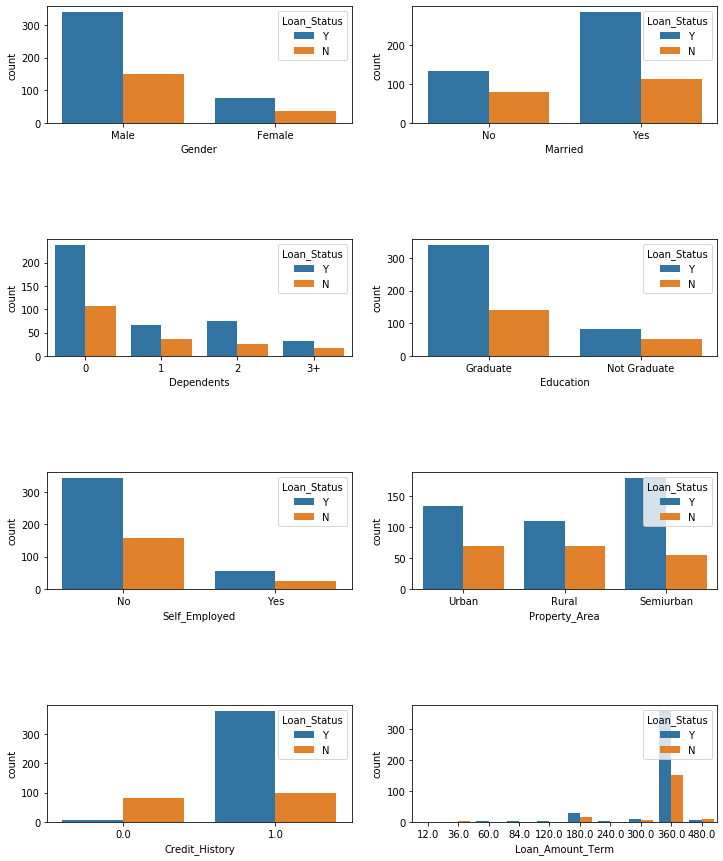

In [4]:
fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=1)


In [5]:
#encoding categorical features
train_df_encoded = pd.get_dummies(train,drop_first=True)
train_df_encoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,NaN,360.0,1.0,1,0,0,0,0,0,0,0,1,1
1,4583,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,1,0,1,1
3,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,1,0,0,1,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,0,0,0,1,1


In [6]:
X = train_df_encoded.drop(columns='Loan_Status_Y')
y = train_df_encoded['Loan_Status_Y']

In [33]:
#training and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify =y,random_state =50)

In [34]:
imp = SimpleImputer(strategy='mean')
imp_train = imp.fit(X_train)
X_train = imp_train.transform(X_train)
X_test_imp = imp_train.transform(X_test)

In [35]:
#Fitting Decision Tree Classifier to dataset
from sklearn.tree import DecisionTreeClassifier
regressor = DecisionTreeClassifier(random_state = 0)
regressor.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [36]:
y_pred_dt = regressor.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred_dt))
print("Training Data F1 Score ", f1_score(y_train,y_pred_dt))

print("Validation Mean F1 Score: ",cross_val_score(regressor,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(regressor,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.7047978583373095
Validation Mean Accuracy:  0.7454339311482169


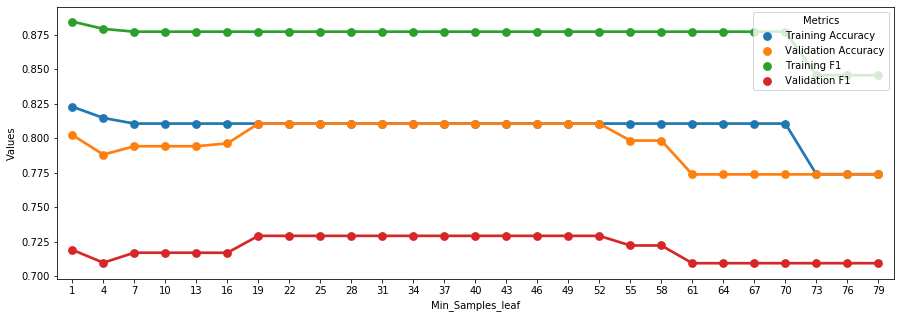

In [37]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []
import numpy as np
for samples_leaf in range(1,80,3): # Sweeping from 1% samples to 10% samples per leaf 
    regressor = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    regressor.fit(X_train,y_train)
    y_training_pred = regressor.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(regressor,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(regressor,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    

Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)

In [38]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test_imp)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8048780487804879
Test F1 Score:  0.8736842105263157
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,16,22,38
1,2,83,85
All,18,105,123


In [39]:
#Fitting Random Forest Regression to the dataset
regressor_rf = RandomForestClassifier(n_estimators = 10, random_state = 0)
regressor_rf.fit(X_train, y_train)
y_pred_rf=regressor_rf.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred_rf.round()))
print("Training Data F1 Score ", f1_score(y_train,y_pred_rf.round()))

print("Validation Mean F1 Score: ",cross_val_score(regressor_rf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(regressor_rf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  0.9816700610997964
Training Data F1 Score  0.9867060561299853
Validation Mean F1 Score:  0.6959746953875495
Validation Mean Accuracy:  0.7473304473304474


In [40]:
y_pred = regressor_rf.predict(X_test_imp)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.7317073170731707
Test F1 Score:  0.8135593220338984
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,18,20,38
1,13,72,85
All,31,92,123


In [41]:
# Training the SVM model on the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_train)

print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(classifier,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(classifier,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  0.6924643584521385
Training Data F1 Score  0.8169696969696969
Validation Mean F1 Score:  0.4062856105969878
Validation Mean Accuracy:  0.6843125128839415


In [42]:
y_pred = classifier.predict(X_test_imp)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6910569105691057
Test F1 Score:  0.8173076923076924
Confusion Matrix on Test Data


Predicted,1,All
True,,
0,38,38
1,85,85
All,123,123


In [43]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_train)

print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(classifier,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(classifier,X_train,y_train,cv=5,scoring='accuracy').mean())


Training Data Set Accuracy:  0.7352342158859471
Training Data F1 Score  0.8275862068965518
Validation Mean F1 Score:  0.47587623411053503
Validation Mean Accuracy:  0.6292310863739435


In [44]:
y_pred = classifier.predict(X_test_imp)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6666666666666666
Test F1 Score:  0.7875647668393784
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,6,32,38
1,9,76,85
All,15,108,123
